<a href="https://colab.research.google.com/github/bob123kk/NLP-Question-Answering/blob/master/Kaggle_Q%26A_LSTM_Fasttext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install fasttext

In [16]:
import os
import json
import gc
import pickle

import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, Masking
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.preprocessing import text, sequence
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import accuracy_score,recall_score, f1_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext

In [17]:
cd '/content/drive/My Drive/Q&A Data/tensorflow2-question-answering'


/content/drive/My Drive/Q&A Data/tensorflow2-question-answering


In [18]:
pwd

'/content/drive/My Drive/Q&A Data/tensorflow2-question-answering'

In [19]:
test_path='./simplified-nq-test.jsonl'
train_path='./simplified-nq-train.jsonl'
submission = pd.read_csv("./sample_submission.csv")

In [20]:
def build_train(train_path, n_rows, sampling_rate=15):
    with open(train_path) as f:
        processed_rows = []

        for i in tqdm(range(n_rows)):
            line = f.readline()
            if not line:
                break

            line = json.loads(line)

            text = line['document_text'].split(' ')
            question = line['question_text']
            annotations = line['annotations'][0]
            example_id = line['example_id']
            start_token_true = line['annotations'][0]['long_answer']['start_token']

            

            if start_token_true != -1:
                for i, candidate in enumerate(line['long_answer_candidates']):
                    label = i == annotations['long_answer']['candidate_index']

                    start = candidate['start_token']
                    end = candidate['end_token']

                    if label or (i % sampling_rate == 0):
                        processed_rows.append({
                            'text': " ".join(text[start:end]),
                            'is_long_answer': label,
                            'question': question,
                            'example_id': example_id,
                            'annotation_id': annotations['annotation_id']
                        })

        train = pd.DataFrame(processed_rows)
        
        return train

In [21]:
def build_test(test_path):
    with open(test_path) as f:
        processed_rows = []

        for line in tqdm(f):
            line = json.loads(line)

            text = line['document_text'].split(' ')
            question = line['question_text']
            example_id = line['example_id']

            for candidate in line['long_answer_candidates']:
                start = candidate['start_token']
                end = candidate['end_token']

                processed_rows.append({
                    'text': " ".join(text[start:end]),
                    'question': question,
                    'example_id': example_id,
                    'sequence': f'{start}:{end}'

                })

        test = pd.DataFrame(processed_rows)
    
    return test

In [22]:
train_data = build_train(train_path,n_rows=8000)
# test = build_test(test_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [23]:
from sklearn.model_selection import train_test_split

Question_ids = list(train_data.example_id.unique())
Q_train_id, Q_valid_id=  train_test_split(Question_ids, test_size=0.33, random_state=42)

train = train_data.loc[train_data['example_id'].isin(Q_train_id)]
valid = train_data.loc[train_data['example_id'].isin(Q_valid_id)]
print('train_shape: ', train.shape)
print('valid_shape: ', valid.shape)

train_shape:  (27894, 5)
valid_shape:  (13446, 5)


In [24]:
print('Number of train questions:', len(train.example_id.unique()))
print('Number of valid questions:', len(valid.example_id.unique()))

Number of train questions: 2706
Number of valid questions: 1334


In [25]:
def compute_text_and_questions(train, test, tokenizer):
    train_text = tokenizer.texts_to_sequences(train.text.values)
    train_questions = tokenizer.texts_to_sequences(train.question.values)
    valid_text = tokenizer.texts_to_sequences(valid.text.values)
    valid_questions = tokenizer.texts_to_sequences(valid.question.values)
    
    train_text = sequence.pad_sequences(train_text, maxlen=300)
    train_questions = sequence.pad_sequences(train_questions)
    valid_text = sequence.pad_sequences(valid_text, maxlen=300)
    valid_questions = sequence.pad_sequences(valid_questions)
    
    return train_text, train_questions, valid_text, valid_questions

In [26]:
tokenizer = text.Tokenizer(lower=False, num_words=80000)

for text in tqdm([train.text, valid.text, train.question, valid.question]):
    tokenizer.fit_on_texts(text.values)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
train_target = train.is_long_answer.astype(int).values
valid_target = valid.is_long_answer.astype(int).values

In [28]:
train_text, train_questions, valid_text, valid_questions = compute_text_and_questions(train, valid, tokenizer)
del train

In [29]:
def build_embedding_matrix(tokenizer, path):
    embedding_matrix = np.zeros((tokenizer.num_words + 1, 300))
    ft_model = fasttext.load_model(path)

    for word, i in tqdm(tokenizer.word_index.items()):
        if i >= tokenizer.num_words - 1:
            break
        embedding_matrix[i] = ft_model.get_word_vector(word)
    
    return embedding_matrix

In [30]:
path = '/content/drive/My Drive/Word2vec/crawl-300d-2M-subword.bin'
embedding_matrix = build_embedding_matrix(tokenizer, path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [31]:
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]

In [32]:
from tensorflow import keras
def build_model(embedding_matrix):
    embedding = Embedding(
        *embedding_matrix.shape, 
        weights=[embedding_matrix], 
        trainable=False, 
        mask_zero=True
    )
    
    q_in = Input(shape=(None,))
    q = embedding(q_in)
    q = SpatialDropout1D(0.2)(q)
    q = Bidirectional(LSTM(100, return_sequences=True))(q)
    q = GlobalMaxPooling1D()(q)
    
    
    t_in = Input(shape=(None,))
    t = embedding(t_in)
    t = SpatialDropout1D(0.2)(t)
    t = Bidirectional(LSTM(150, return_sequences=True))(t)
    t = GlobalMaxPooling1D()(t)
    
    hidden = concatenate([q, t])
    hidden = Dense(300, activation='relu')(hidden)
    hidden = Dropout(0.5)(hidden)
    hidden = Dense(300, activation='relu')(hidden)
    hidden = Dropout(0.5)(hidden)
    
    out1 = Dense(1, activation='sigmoid')(hidden)
    
    model = Model(inputs=[t_in, q_in], outputs=out1)
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[keras.metrics.AUC(name='auc')])

    return model

In [33]:
model = build_model(embedding_matrix)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    24000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, None, 300)    0           embedding[0][0]              

In [34]:
train_history = model.fit(
    [train_text, train_questions], 
    train_target,
    epochs=2,
    validation_split=0.2,
    batch_size=1024
)

Epoch 1/2
22/22 [==============================] - 58s 2s/step - loss: 0.3763 - auc: 0.5479 - val_loss: 0.3046 - val_auc: 0.6809
Epoch 2/2
22/22 [==============================] - 35s 2s/step - loss: 0.2675 - auc: 0.7906 - val_loss: 0.2552 - val_auc: 0.8254


In [35]:
baseline_results = model.evaluate([valid_text,valid_questions], valid_target,
                                  batch_size=1024, verbose=0)


for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

loss :  0.24650713801383972
auc :  0.8396186828613281



In [36]:
baseline_predict  =  model.predict([valid_text,valid_questions],batch_size=1024, verbose=0)

In [37]:
valid['predictions'] = baseline_predict

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
valid.head()

,text,is_long_answer,question,example_id,annotation_id,predictions
0,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False,which is the most common use of opt-in e-mail ...,5655493461695504401,593165450220027640,0.039368
1,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False,which is the most common use of opt-in e-mail ...,5655493461695504401,593165450220027640,0.001140
2,<P> Email marketing has evolved rapidly alongs...,False,which is the most common use of opt-in e-mail ...,5655493461695504401,593165450220027640,0.208265
3,<Li> Advertisers can reach substantial numbers...,False,which is the most common use of opt-in e-mail ...,5655493461695504401,593165450220027640,0.012504
4,<P> A common example of permission marketing i...,True,which is the most common use of opt-in e-mail ...,5655493461695504401,593165450220027640,0.215678


In [39]:
max_pred = valid.groupby(['example_id'])['predictions'].transform('max')
valid['pred_target'] = np.where(valid['predictions'].eq(max_pred), 1,0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
# helper function
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix')
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

In [46]:
valid_set_index =valid.set_index('example_id')



,text,is_long_answer,question,annotation_id,predictions,pred_target
example_id,,,,,,
5655493461695504401,<Table> <Tr> <Td> </Td> <Td> ( hide ) This art...,False,which is the most common use of opt-in e-mail ...,593165450220027640,0.039368,0
5655493461695504401,<Tr> <Td> <Ul> <Li> Pay - per - click </Li> <L...,False,which is the most common use of opt-in e-mail ...,593165450220027640,0.001140,0
5655493461695504401,<P> Email marketing has evolved rapidly alongs...,False,which is the most common use of opt-in e-mail ...,593165450220027640,0.208265,0
5655493461695504401,<Li> Advertisers can reach substantial numbers...,False,which is the most common use of opt-in e-mail ...,593165450220027640,0.012504,0
5655493461695504401,<P> A common example of permission marketing i...,True,which is the most common use of opt-in e-mail ...,593165450220027640,0.215678,1
...,...,...,...,...,...,...
2139522855799723903,<Tr> <Td> 28 </Td> <Td> Argentina </Td> <Td> 2...,False,what is the milk consumption per capita (kg) i...,16697149840373109551,0.000452,0
2139522855799723903,<Tr> <Td> 43 </Td> <Td> Russia </Td> <Td> 172....,False,what is the milk consumption per capita (kg) i...,16697149840373109551,0.000443,0
2139522855799723903,<Tr> <Td> 58 </Td> <Td> Antigua and Barbuda </...,False,what is the milk consumption per capita (kg) i...,16697149840373109551,0.000592,0


In [48]:
B_f1_score = 1/valid_set_index.groupby(level='example_id')['text'].count().mean()

Baseline f1_score: 0.09921166146065744
Model f1_score: [0.93741744 0.43178411]


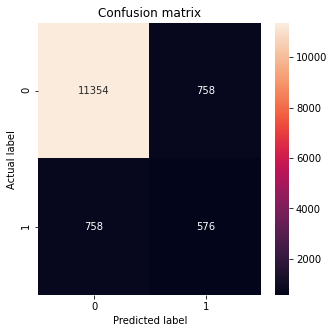

In [49]:

print('Baseline f1_score: {}'.format(B_f1_score))
f1_scor = f1_score(valid_target, valid.pred_target,average=None)

plot_cm(valid_target, valid.pred_target)
print('Model f1_score: {}'.format(f1_scor))

### Saving Model

In [42]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
model.save('model.h5')

In [44]:

test = build_test(test_path)


test.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


,text,question,example_id,sequence
0,"<Table> <Tr> <Th_colspan=""2""> High Commission ...",who is the south african high commissioner in ...,-1220107454853145579,18:136
1,"<Tr> <Th_colspan=""2""> High Commission of South...",who is the south african high commissioner in ...,-1220107454853145579,19:30
2,<Tr> <Th> Location </Th> <Td> Trafalgar Square...,who is the south african high commissioner in ...,-1220107454853145579,34:45
3,<Tr> <Th> Address </Th> <Td> Trafalgar Square ...,who is the south african high commissioner in ...,-1220107454853145579,45:59
4,<Tr> <Th> Coordinates </Th> <Td> 51 ° 30 ′ 30 ...,who is the south african high commissioner in ...,-1220107454853145579,59:126


### Load Model

In [45]:
/content/drive/My Drive/Q&A Data/tensorflow2-question-answering/model.h5

SyntaxError: ignored

In [ ]:
pwd

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model.h5')
model.summary()

In [ ]:
def compute_text_and_questions(test, tokenizer):
    test_text = tokenizer.texts_to_sequences(test.text.values)
    test_questions = tokenizer.texts_to_sequences(test.question.values)
    
    test_text = sequence.pad_sequences(test_text, maxlen=300)
    test_questions = sequence.pad_sequences(test_questions)
    
    return test_text, test_questions

In [ ]:
with open('./tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
test_text, test_questions = compute_text_and_questions(test, tokenizer)

In [ ]:
del test['text']
del test['question']

### Prediction

In [ ]:
test_target = model.predict([test_text, test_questions], batch_size=512)

In [ ]:
test['target'] = test_target

result = (
    test.query('target > 0.3')
    .groupby('example_id')
    .max()
    .reset_index()
    .loc[:, ['example_id', 'sequence']]
)

result.head()

In [ ]:
result = pd.concat([
    result.assign(example_id=lambda example_id: example_id + '_long'),
    result.assign(example_id=lambda example_id: example_id + '_short')
])
result.head()

In [ ]:
submission.head()

In [ ]:
final_submission = (
    submission.drop(columns='PredictionString')
    .merge(result, on=['example_id'], how='left')
)

final_submission.head()

In [ ]:
final_submission.to_csv("submission.csv", index=False)